In [47]:
import matplotlib.pyplot as plt
import numpy as np 

# Utility functions
def plot_weights(w_D, v_G):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(np.arange(np.shape(w_D)[0]), w_D, label="discriminator")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(np.arange(np.shape(w_D)[0]), v_G, label="generator")
    plt.legend()
    plt.show()
    
    print("Recovered mean from generator: {}".format(np.mean(v_G, axis=0)))
    print("Last mean from generator: {}".format(v_G[-1]))

## Learning the Mean of  Multi-Variate Gaussians with a Linear WGAN

We consider the following very simple GAN example: The data are generated by a multivariate normal distribution of the form: 
\begin{equation}
x \sim N({\bf v}, I)
\end{equation}
Where $v\in \mathbb{R}^d$.

We consider a WGAN, where the discriminator is a linear function based on a parameter $w_D \in \mathbb{R}^d$, which takes as input a data point $x$ and outputs the inner product with $w_D$, i.e.: 
\begin{equation}
f_D(x; w_D) = \langle w_D, x \rangle
\end{equation}
The generator is another linear function based on a parameter $v_G$, which takes as input a random noise vector $z\sim N(0, I)$ in $\mathbb{R}^d$ and outputs the displaced random vector $z + v_D$, i.e.:
\begin{equation}
f_G(z; v_G) = z + v_G
\end{equation}
The goal of the generator is to figure out the true distribution, i.e. to converge to $v_G = v$ for the true $v$.

The WGAN loss is based on the intution that the space of functions of the discriminator will be large enough that they will approximate the Wasserstein metric between the true distribution and the distribution produced by the generator. For the specific class of discriminator functions that we are using the latter boils down to:
\begin{equation}
\sup_{w_D} \mathbb{E}_{x\sim N(v, I)}\left[ f_D(x; w_D) \right] - \mathbb{E}_{z\sim N(0,I)}\left[f_D(f_G(z; v_G); w_D)\right]  = \sup_{w_D} \mathbb{E}_{x\sim N(v, I)}\left[ \langle w_D, x \rangle \right] - \mathbb{E}_{z\sim N(0,I)}\left[\langle w_D, z + v_G \rangle\right] 
\end{equation}

The generator is trying to minimize the latter metric, which leads to the following zero-sum game:
\begin{equation}
\inf_{v_G} \sup_{w_D} \mathbb{E}_{x\sim N(v, I)}\left[ \langle w_D, x \rangle \right] - \mathbb{E}_{z\sim N(0,I)}\left[\langle w_D, z + v_G \rangle\right] 
\end{equation}



In [32]:
# Parameters of distribution
dim = 2
v = [3, 4]

## Simulations without Sampling Noise

We first consider the case where we optimize the true expectations above rather than assuming that we only get samples of $x$ and samples of $z$. In this case the expected zero-sum game takes the following very simple form:
\begin{equation}
\inf_{v_G} \sup_{w_D}   \langle w_D, v-v_G \rangle
\end{equation}

We see here that one equilibrium for the above game is for the generator to choose $v_G=v$ and for the discriminator to choose $w_D = 0$.

We will simulate simultaneous training in this zero-sum game under the GD and under Optimistic GD and we will examine convergence of the dynamics to this equilibrium. We will see that SGD does not converge to an equilibrium and only the running average of the solutions is an equilibrium, while optimistic SGD converges to an equilibrium pointwise. In the next section we will also incorporate sampling errors and look at stochastic gradient descent and its optimistic variant.

For this simple zero sum game the GD dynamics take the simple form:
\begin{align}
w_D^{t+1} =& w_D^{t} + \eta_D (v - v_G^{t})\\
v_G^{t+1} =& v_G^{t} + \eta_G w_D^t
\end{align}
while the optimistic GD dynamics take the form:
\begin{align}
w_D^{t+1} =& w_D^{t} + 2\eta_D (v - v_G^{t}) - \eta_D (v-v_G^{t-1})\\
v_G^{t+1} =& v_G^{t} + 2\eta_G w_D^t - \eta_G w_D^{t-1} 
\end{align}

To help GD not cycle, we also employ standard approaches in WGAN training:
- Weight clipping: we cap the weights to not go outside the range [-H, H], to ensure the discriminator represents a Lipschitz function
- Asymmetric training: we train the generator multiple times in between one training step of the generator

We observe that GD training cycles even after this standard modifications in WGAN training. On the other hand, optimistic GD does not cycle even if we don't utilize these modifications.

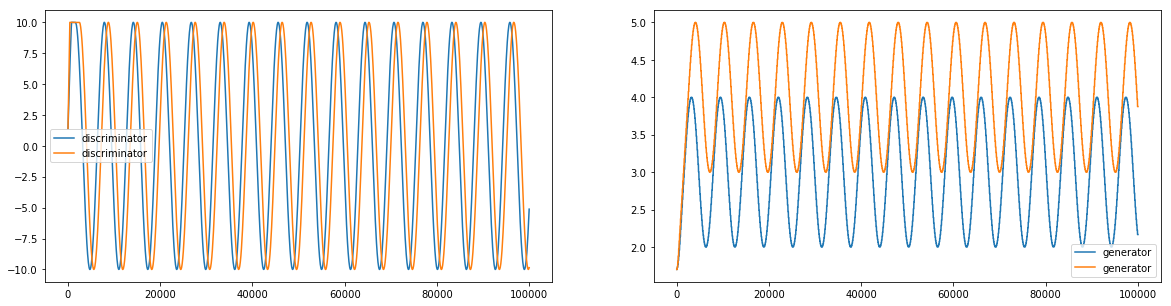

Recovered mean from generator: [ 3.00285715  3.9895086 ]
Last mean from generator: [ 2.16611313  3.87600603]


In [61]:
# GD Training on the expected loss
T = 100000
clip_D = 10
clip_G = 10
eta_D = .01
eta_G = .01
train_gen_every = 100
w_D = 1.4*np.ones((T, dim))
v_G = 1.7*np.ones((T, dim))

for t in range(1,T):
    w_D[t] = np.clip(w_D[t-1] + eta_D * (v-v_G[t-1]), -clip_D, clip_D)
    v_G[t] = np.clip(v_G[t-1] + eta_G * (w_D[t-1]), -clip_G, clip_G) if t % train_gen_every == 0 else v_G[t-1]

plot_weights(w_D, v_G)

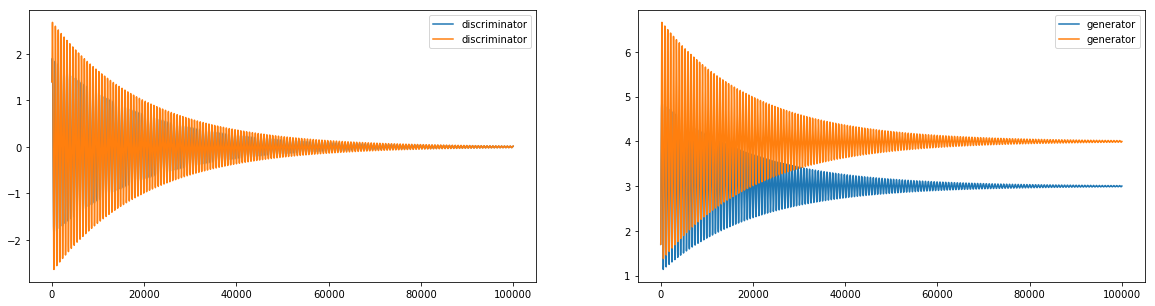

Recovered mean from generator: [ 3.00136161  4.00133587]
Last mean from generator: [ 3.00345445  3.99993121]


In [49]:
# Optimistic GD Training on the expected loss
T = 100000
eta_D = .01
eta_G = .01
w_D = 1.4*np.ones((T, dim))
v_G = 1.7*np.ones((T, dim))

for t in range(2,T):
    w_D[t] = w_D[t-1] + 2 * eta_D * (v-v_G[t-1]) - eta_D * (v-v_G[t-2])
    v_G[t] = v_G[t-1] + 2 * eta_G * w_D[t-1] - eta_G * w_D[t-2]

plot_weights(w_D, v_G)

## With Sampling Noise

In the case of sampling noise, we assume that we have a set of real samples $x_1,\ldots, x_N$ and a set of noise samples $z_1,\ldots, z_N$ and we are trying to minimize the empirical WGAN loss:
\begin{equation}
\inf_{v_G} \sup_{w_D} \frac{1}{N} \sum_{i=1}^N \langle w_D, x_i \rangle - \frac{1}{n} \sum_{i=1}^N  \langle w_D, z_i + v_G \rangle 
\end{equation}
Equivalently this simplifies to:
\begin{equation}
\inf_{v_G} \sup_{w_D} \frac{1}{N} \sum_{i=1}^N \langle w_D, x_i - z_i - v_G \rangle 
\end{equation}

We will train the generator and discriminator via stochastic gradient descent, i.e. at every time using only a single sample of $x_i$ and a single sample of $z_i$ to approximate the gradient of the latter emprical loss. This leads to the following training scheme:
\begin{align}
w_D^{t+1} =& w_D^{t} + \eta_D (x_t - z_t - v_G^{t})\\
v_G^{t+1} =& v_G^{t} + \eta_G w_D^t
\end{align}
Similarly optimistic stochastic GD dynamics take the form:
\begin{align}
w_D^{t+1} =& w_D^{t} + 2\eta_D (x_t - z_t - v_G^{t}) - \eta_D (x_{t-1} - z_{t-1} - v_G^{t-1})\\
v_G^{t+1} =& v_G^{t} + 2\eta_G w_D^t - \eta_G w_D^{t-1} 
\end{align}

To avoid the huge sampling variance, which is contrary to the stability that optimistic gradient decent requires, we will also use a large mini-batch size at each training iteration, i.e. we use averages of a small minibatch of $x_i$ and $z_i$. We test the quality of convergence as a function of the size of the mini-batch.


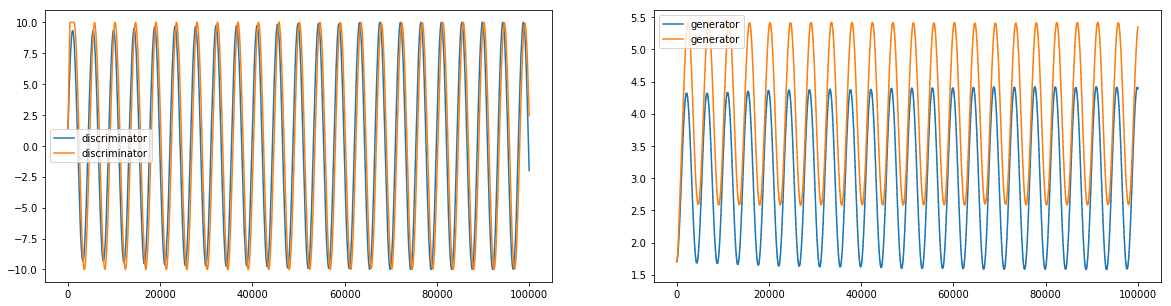

Recovered mean from generator: [ 3.00326943  3.99063621]
Last mean from generator: [ 4.39173178  5.34849273]


In [50]:
# SGD Training on Sampled Loss with minibatching
T = 100000
minibatch = 200
clip_D = 10
clip_G = 10
eta_D = .01
eta_G = .01
train_gen_every = 50

# Initialize weights and sample
w_D = 1.4*np.ones((T, dim))
v_G = 1.7*np.ones((T, dim))
xs = np.random.multivariate_normal(mean=v, cov = np.eye(dim), size=(T, minibatch))
zs = np.random.multivariate_normal(mean=np.zeros(dim), cov = np.eye(dim), size=(T, minibatch))

# Compute average of minibatches
bxs = np.mean(xs, axis=1)
bzs = np.mean(zs, axis=1)

for t in range(1,T):
    w_D[t] = np.clip(w_D[t-1] + eta_D * (bxs[t-1] - bzs[t-1] - v_G[t-1]), -clip_D, clip_D)
    v_G[t] = np.clip(v_G[t-1] + eta_G * (w_D[t-1]), -clip_G, clip_G) if t % train_gen_every == 0 else v_G[t-1]

plot_weights(w_D, v_G)

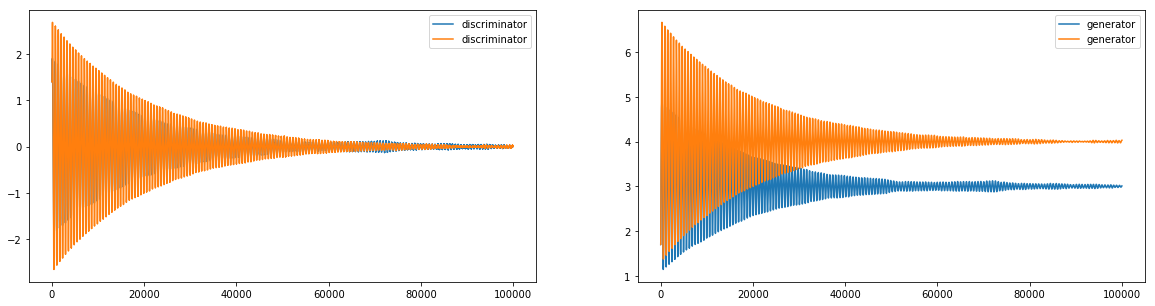

Recovered mean from generator: [ 3.0013569   4.00131289]


In [38]:
# Optimistic SGD Training on Sampled Loss with minibatching=2000
T = 100000
minibatch = 2000
eta_D = .01
eta_G = .01
w_D = 1.4*np.ones((T, dim))
v_G = 1.7*np.ones((T, dim))
xs = np.random.multivariate_normal(mean=v, cov = np.eye(dim), size=(T, minibatch))
zs = np.random.multivariate_normal(mean=np.zeros(dim), cov = np.eye(dim), size=(T, minibatch))

bxs = np.mean(xs, axis=1)
bzs = np.mean(zs, axis=1)

for t in range(2,T):
    w_D[t] = w_D[t-1] + 2 * eta_D * (bxs[t-1] - bzs[t-1] - v_G[t-1]) - eta_D * (bxs[t-2] - bzs[t-2] -v_G[t-2])
    v_G[t] = v_G[t-1] + 2 * eta_G * w_D[t-1] - eta_G * w_D[t-2]

plot_weights(w_D, v_G)

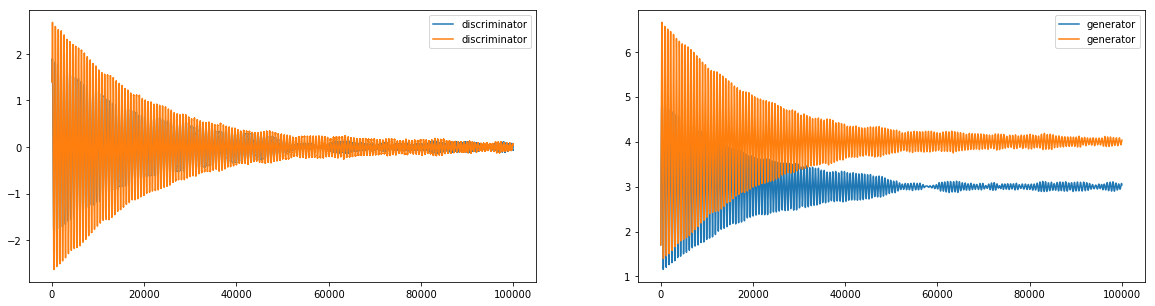

Recovered mean from generator: [ 3.0007803   4.00171095]
Last mean from generator: [ 3.03908456  4.03405149]


In [51]:
# Optimistic SGD Training on Sampled Loss with minibatching=200
T = 100000
minibatch = 200
eta_D = .01
eta_G = .01
w_D = 1.4*np.ones((T, dim))
v_G = 1.7*np.ones((T, dim))
xs = np.random.multivariate_normal(mean=v, cov = np.eye(dim), size=(T, minibatch))
zs = np.random.multivariate_normal(mean=np.zeros(dim), cov = np.eye(dim), size=(T, minibatch))

bxs = np.mean(xs, axis=1)
bzs = np.mean(zs, axis=1)

for t in range(2,T):
    w_D[t] = w_D[t-1] + 2 * eta_D * (bxs[t-1] - bzs[t-1] - v_G[t-1]) - eta_D * (bxs[t-2] - bzs[t-2] -v_G[t-2])
    v_G[t] = v_G[t-1] + 2 * eta_G * w_D[t-1] - eta_G * w_D[t-2]

plot_weights(w_D, v_G)

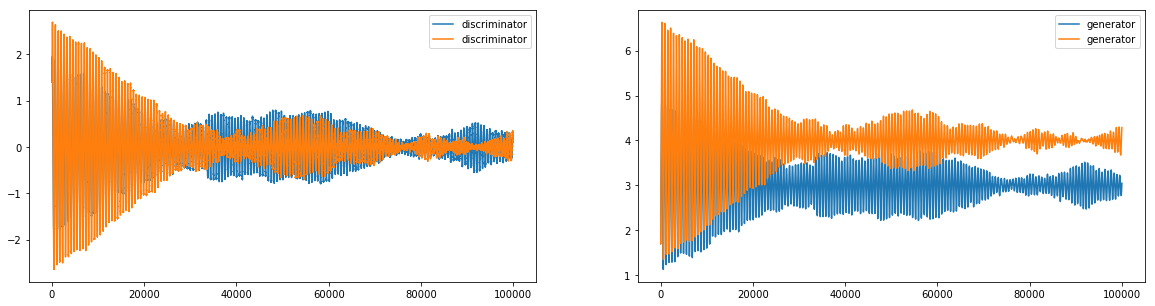

Recovered mean from generator: [ 2.99950507  4.00091705]
Last mean from generator: [ 3.04709506  4.28775511]


In [52]:
# Optimistic SGD Training on Sampled Loss with minibatching=20
T = 100000
minibatch = 20
eta_D = .01
eta_G = .01
w_D = 1.4*np.ones((T, dim))
v_G = 1.7*np.ones((T, dim))
xs = np.random.multivariate_normal(mean=v, cov = np.eye(dim), size=(T, minibatch))
zs = np.random.multivariate_normal(mean=np.zeros(dim), cov = np.eye(dim), size=(T, minibatch))

bxs = np.mean(xs, axis=1)
bzs = np.mean(zs, axis=1)

for t in range(2,T):
    w_D[t] = w_D[t-1] + 2 * eta_D * (bxs[t-1] - bzs[t-1] - v_G[t-1]) - eta_D * (bxs[t-2] - bzs[t-2] -v_G[t-2])
    v_G[t] = v_G[t-1] + 2 * eta_G * w_D[t-1] - eta_G * w_D[t-2]

plot_weights(w_D, v_G)